# Description
This is a model which can create coupled networks of a desired type and change their parameters to observe which of them affect synchronization. 

It carries out the following functions:
    1. Create individual network groups with their synapses --> uses BrianVis.network_indv(...)
    2. Create synapse group of coupled networks with monitors to record each network --> BrianVis.network_coupling(..)
    3. Make changes to individual parameters of network groups, synapses and run times
    4. Run the coupled networks in the following pattern:
               a. Disconnected networks for a time t1*s: coupled synaptic weights will be zero
               b. Connected(coupled) networks for a time t2*s: coupled synaptic weights reset to values obtained in step 2
               c. Disconnected networks for a time t1*s: coupled synaptic weights set to zero again
    5. Output spikemonitor voltages and times so they can be graphed

# Goals:
- To simulate coupled networks while varying their parameters
- To observe network behavior in coupled vs uncoupled states

## Importing Python Modules and Initializing Classes

In [2]:
# Please make sure kernel is Python 2 and not Python 3. 
# Currently Brian 2 does not work correctly on Python3 even if the package is installed
# Refer to README file on GitHub for how to change the Jupyter notebook environment to Python2
# Refer to README file on GitHub for how to setup PySpike

import networkx as nx
from brian2 import *
import numpy as np
import time
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
#import pyspike as spk
%matplotlib inline

## Defining Classes

### Types: 
* Visualization
* Brian Visualization
* Adjacency Matrix
* Spike Stats
* Synchronicity Calculation

In [3]:
class Visualization:
    '''
    Function 2: Visualize neural network
    Inputs graph G 
    Returns cluster coefficient & characteristic path length
        & plot of connections between neurons (color-coded)
    For more info: see collective dynamics paper
    
    Description:
    From network model, determines cluster coefficient and characteristic path length for each
        node. For each network, will take average of those values, respectively and yield 
        single integer value.
    From network model, will output plot of connections, color-coded for excitatory and
        inhibitory.
    
    Returns:
        cc_avg: Cluster coefficient averaged over all nodes
        ex_in_plot: Plot of colored excitatory/inhibitory connections
        cpl_avg: Number of edges at shortest path over all nodes 
        
    Parameters:
        G: NetworkX Graph from Function 1
    '''
    def __init__(self):
        #plt.clf() # Clears any previous figures
        plt.close() # Clears any figure windows

    def cluster_coeff(self,G):        
        cc = nx.clustering(G) # calculate clustering co-eff according to different rules eg. no of triangles going through node
        # outputs co-eff for all or specified nodes in dict form
        cc_y=[]
        for idx in cc:
            cc_y=np.append(cc_y,cc[idx]) # access and append dict values (co-effs in this case) to array
        
        cc_avg = np.ndarray.mean(cc_y, dtype=np.float64)
        return cc_avg
    
    def ex_in_connec(self,G,connect_W,new_coord):
        plt.figure()
        red_patch = mpatches.Patch(color='red', label='Excitatory')
        blue_patch = mpatches.Patch(color='blue', label='Inhibitory')
        plt.legend(handles=[red_patch,blue_patch])
        suptitle('Structural Connections', fontsize=14, fontweight='bold')

        edges = G.edges() # list of tuple pairs
        nodes = G.nodes() # array of nodes

        custom_color={}
        for idx in range(len(connect_W)):
            if connect_W[idx] < 0:
                inhib_edge = new_coord[idx]
                G.add_edge(*inhib_edge)     # adds an inhibitory edge connection to graph if it's not already there
                custom_color[inhib_edge]='b'
            else:
                excit_edge = new_coord[idx]
                G.add_edge(*excit_edge)
                custom_color[excit_edge]='r'
        if 0:
            for idx,idy in enumerate(edges):
                x1,y1 = edges[idx]
                if connect_W < 0:
                    inhib_edge = (x1,y1)
                    G.add_edge(x1,y1)
                    custom_color[x1,y1]='b' # Stores color of edges in dict
                else:
                    excit_edge = (x1,y1)
                    G.add_edge(x1,y1)
                    custom_color[x1,y1]='r'
        
        ex_in_plot=nx.draw_networkx(G,node_color='w',
                         with_labels=True,
                         node_list=nodes,
                         #node_size=50,
                         node_size=200,
                         edge_list=custom_color.keys(),
                         edge_color=custom_color.values(),
                         label='Blue=Inhibitory, Red=Excitatory')
        #plt.savefig("Structural Connections.png")
        
    def char_path_len(self,G):
        cpl = nx.all_pairs_shortest_path_length(G) # shortest path lengths. Gen. returns tuple with source and target dict
        my_array = []
        my_key = []
        cpl_count = []
        for idx in cpl: # looping through each source node and looking at no of targets and length to target nodes
            myarray = cpl[idx[1]] # cpl is a generator object. idx is a tuple (source, target dict). Should be idx[1].
            min_val = min(ii for ii in myarray if ii > 0) # Find min length
            for key,length in myarray.iteritems():
                if length == min_val:
                    my_key = np.append(my_key,key) # array of target nodes with min length for specific source node
            my_count = len(my_key) # Find number of edges of that length
            cpl_count = np.append(cpl_count,my_count)
            my_key = []
            cpl_avg = np.mean(cpl_count) # Find average of those edges
        return cpl_avg

In [4]:
class BrianVisualization:
    '''
    Function 4: Visualization of Brian 
    Define LIF neural population in Brian
    Call to save spike times
    Call to plot voltage monitor
    Call to plot raster plot
    Call to plot histogram
    
    Description:
    Will plot the voltage monitor, raster plot, and histogram of neural network
    
    Returns:
        G: NeuronGroup
        spike_times: Spike times for neuron 0
        all_spikes: Spike times for all neurons
        
    
    Parameters:
        statemon: StateMonitor
        spikemon: SpikeMonitor
        run_time: Simulation run time
    
    '''
    def __init__(self):
        plt.clf() # Clears any previous figures
        plt.close() # Clears any figure windows
        
        start_scope()
    
    def network_indv(self,rows,cols,connect_W,N,PInput):
        # rows and cols 1-D arrays of source and target neurons that are connected as defined in graph from networkx
        # connect_W: 1-D array of strength of connections corresponding to source and target neuron pairs 
        '''
        For full synch: G1.v = fixed
                        PI = off
        '''
        eqs = neuron_diffeqns # Defined in the input parameter block 
                
        G1 = NeuronGroup(N, eqs, threshold='v>v_th', reset='v=v_r', refractory=10*ms, method=integ_method) #integ_method defined in input parameter block
        G1.v = v_c # initial voltage value defined in input block
        '''
        Injection current is constant but with slight perturbations from PoissonInput, if that function is active
        To get rid of highly synchronized, G1.v='rand()' and turn on P1
        '''
        G1.I = I_c # Constant current define in input block  
        G1.tau_gi = tau_gi_c 
        
        # PoissonInput injection current -- changes each neuron's firing rate
        # Each neuron has different input current depending on Poisson distribution
        PI_num = 0.8*N 
        #subG1 = G1[int(PI_num):] # Top 20% of total neurons stimulated
        subG1 = G1[:] # All neurons stimulated via Poisson 
        '''
        PoissonInput(target,target_var,N,rate,weight)
        target: which neurons to send PoissonInput
        target_var: which variable that is being changed from input
        N: number of inputs (more input = higher firing rate)
        rate: rate of input (100Hz = 10ms per spike)
        weight: amount added to voltage
        '''
        #P1 = PoissonInput(subG1, 'v', 5, 100*Hz, weight=0.1) # PoissonInput on
        P1 = PoissonInput(subG1, 'v', 5, 100*Hz, weight=PInput) # PoissonInput off if PInput = 0
        
        S1 = Synapses(G1, G1, 'w : volt', on_pre='v_post += w') # w is the synapse weight added to the signal
        S1.connect(i=rows, j=cols) # Adjacency matrix from Adj.weighted, this uses network structure defined on networkx
        S1.w = connect_W/float(100) # Weighted matrix defined from networkx graph 
               
        return G1,S1,P1

    def network_coupling(self,N,p_couple,w_couple,G1,G2,SG_name):
        '''
        Should see how coupling between different subpopulation has global effects (raster plot)
            - Could see difference if neurons have same firing rate (non-PoissonInput) vs. different firing rate (all-PoissonInput)
            - May only want to record (Statemon, Spikemon) from this last coupling (G2) to save resources
                - See Monitoring Synaptic Variables from http://brian2.readthedocs.io/en/2.0.1/user/synapses.html
            = Can introduce multiple output synapses (multisynaptic_index from http://brian2.readthedocs.io/en/2.0.1/user/synapses.html)
                - Or more simply "S.connect(i=numpy.arange(10), j=1)"
        '''
        S3 = Synapses(G1,G2, 'w: volt', on_pre='v_post += w',name=SG_name)#, delay=5*ms) # G1 drives G2
        
        ### Manually defining coupling ###
        p_couple2 = p_couple*N
        i_couple2 = 0.8*N
        
        # If want 1:1 for only first p_couple% neurons (excitatory --> excitatory)
        if connect_type == 'ee':
            c_rows = list(arange(0,p_couple2,dtype=int)) # Source neurons
            c_cols = list(arange(0,p_couple2,dtype=int)) # Target neurons
        elif connect_type == 'ii':
            c_rows = list(arange(N-i_couple2,N,dtype=int))
            c_cols = list(arange(N-i_couple2,N,dtype=int))
        elif connect_type == 'ie':
            c_rows = list(arange(N-i_couple2,N,dtype=int))
            c_cols = list(arange(0,p_couple2,dtype=int))
        elif connect_type == 'ei':
            c_rows = list(arange(0,p_couple2,dtype=int))
            c_cols = list(arange(N-i_couple2,N,dtype=int))
        
        S3.connect(i=c_rows, j=c_cols) # Manually defined coupling
        S3.w = w_couple
        ###################################
        
        ##### Probabilistic coupling #####
        #S3.connect(p=0.05) # Probabilistic connection - Chance that G2 will connect with and spike from G1
        #S3.w = 0.02
        #S3.connect(p=p_couple)
        ###################################
                
        # Coupling matrix
        coup_mat = [[0 for x in range(N)] for y in range(N)]

        for ii in range(len(c_rows)):
            for jj in range(len(c_cols)):
                coup_mat[ii][ii] = 1      # Matrix has 1s for connections and 0s for none

        statemon1 = StateMonitor(G1, 'v', record=0,name='statemon1_'+ G1.name) # Records just neuron 0 to save resources
        spikemon1 = SpikeMonitor(G1, variables='v',)
        statemon2 = StateMonitor(G2, 'v', record=0,name='statemon2_'+ G2.name) # Records just neuron 0 to save resources
        spikemon2 = SpikeMonitor(G2, variables='v')

        return statemon1,spikemon1,statemon2,spikemon2,c_rows,c_cols,coup_mat,S3
        
    def spike_time(self,spikemon):
        all_values = spikemon.all_values()
        spike_times = all_values['t'][0] # Spike times for just neuron 0
        all_spikes = spikemon.t/ms # Spike times for all neurons
        
        return spike_times,all_spikes
        
    def voltage_monitor(self,statemon):
        plot(statemon.t/ms, statemon.v[0])
        #plot(statemon.t/ms, statemon.v[1])  # Plots second neuron      
        ylabel('Voltage (V)')
        xlabel('Time (ms)')
        
    def raster_plot(self,spikemon,spikemon_other):
        #ion()
        plot(spikemon.t/ms, spikemon.i, '.r')
        plot(spikemon_other.t/ms, spikemon_other.i, '.k') # Plots overlay of each network
        plt.xlim([0,105])
        plt.xticks(np.arange(0, 120, step=20))
        xlabel('Time (ms)')
        ylabel('Neuron index');
        #plt.show(block=True)
        
    def spike_hist(self,run_time,all_spikes):
        my_bins = arange(0,run_time+2,2)
        plt.hist(all_spikes, bins=my_bins)
        plt.xlim([0,105])
        plt.yticks(np.arange(0, 30, step=2))
        plt.margins()
        xlabel('Time (ms)')
        ylabel('Total number of spikes')

In [5]:
class AdjacencyMatrix:  
    '''
    Function 1: Weighted adjacency matrix
    Call to initiate adjacency matrix
    Call to choose which neural network topology with given parameters
    
    Description:
    Given parameters, constructs network with adjacency matrix and applies random weights.
    
    Returns:
        Graph: NetworkX Graph
        A: Adjacency matrix. Sparse matrix
        rows: Presynaptic neurons
        cols: Postsynaptic neurons
        connect_W: Weights for each E/I connection (in order of rows,cols)
    
    Parameters:
        n: nodes
        m: edges
        k: neighbor connections
        p: probability 
        d: degrees
    '''
    def __init__(self,n): 
        plt.clf() # Clears any previous figures
        plt.close() # Clears any figure windows
        
    def random(self,n,p): 
        # Interchangeable based on UI for different types of topography
        #G = nx.dense_gnm_random_graph(n,m) # Uses NetX to generate random topography, need to add input param m
        Graph = nx.gnp_random_graph(n,p)
        #nx.draw(G, with_labels=True) # Draws connectivity figure
        #plt.savefig("Random.png") # Saves connectivity figure as Random.png

        # Extracts ADJACENCY MATRIX from topography and rearranges to manageable array of (n*n) elements
        A = nx.adjacency_matrix(Graph) # Assigns A as adjacency matrix (which nodes are connected)
        return A, Graph 
    
    def small_world(self,n,k,p): 
        Graph = nx.newman_watts_strogatz_graph(n,k,p) 
        #nx.draw(G, with_labels=True)
        #plt.savefig("Small-world.png")
        A = nx.adjacency_matrix(Graph)
        return A, Graph
    
    def unidir_coord(self,rows, cols):
        # function to remove duplicate connections like (0,3) and (3,0) so that all connections are uni- and not bi-directional
        coord = zip(rows,cols) # To get an array of coordinate pair tuples, to define node pairs or edges 
        new_pairs = set(tuple(sorted(l)) for l in coord) # set removes duplicate tuples that are now ordered pairs
                                                            # set(array of tuples)
        g = np.array(list(new_pairs)) #array of 1 by 2 neuron pair vectors that are connected to each other
                                      # In each 1 by 2 vector: column 0 is source neuron and column 1 is target neuron
        new_rows = g[:,0] #1-D array of all source neurons i
        new_cols = g[:,1] #1-D array of all target neurons j
        new_coord = zip(new_rows,new_cols) # list of tuples, source and target ordered pairs with no duplicates
        return new_coord, new_rows, new_cols
    
    def adj_synapse_type(self,A):
        ### Define connections as inhibitory or excitatory in the adjacency matrix
        A_mat = A.todense() # Converts adjacency matrix from 'scipy.sparse.csr.csr_matrix' to numpy matrix                              
        rows, cols = np.nonzero(A_mat) # Two arrays of index positions for connections
        [new_coord, new_rows, new_cols] = self.unidir_coord(rows,cols) # Removes duplicate connections
        connect = len(new_rows) # number of connections or 1s in adjacency matrix

        for i in range(connect):
            x = new_rows[i]
            y = new_cols [i]
            if x>(excit-1) or y>(excit-1):   # Checking if either source or target neuron belongs to upper 20% of n 
                A_mat[x,y] = A_mat[x,y]*-1   # Inhibitory neuron defined, weight is made negative
                                             # not necessary to repeat for symmetric part of the matrix as it won't be used

        # Constructing array of unweighted connections
        connect_A = [] # Initializaing empty connections array
        for i in range(connect):
            x = new_rows[i]
            y = new_cols [i]
            connect_A.append(A_mat[x,y])
        connect_A = np.array(connect_A) # Converting data type list to numpy array
        return connect_A,new_coord,new_rows,new_cols

In [6]:
class Spike_Stats:
    '''
    Description: Given spike times of each neuron, statistical parameters of ISI(Inter-Spike-Interval) can be calculated
                 like mean, variance, co-efficent of variation. Spike trains can also be compared to produce correlation
                 coefficients
    
    Parameters: 
    '''
    
    def __init__(self): # Not sure what to do here yet
        pass
    
    def ISI_stats(self,spikemon):
        neuron_spikes = spikemon.spike_trains() # Dictionary with dict keys as neuron indices and 
                                         # dict values as an array of spike times for that neuron
        firing_n = list(set(sort(spikemon.i))) # To create a set or list of all unique neuron indices that have spiked
                                                # in order to calculate statistical parameters for each unique neuron
            
        ISI = {} # Create an empty dictionary to contain dict keys as neuron indices and dict values as an array of ISIs
        ISI_mean = {} # Dict for ISI mean of each neuron index
        ISI_var = {} # Dict for ISI variance of each neuron index
        ISI_cv = {} # Dict for ISI co-efficient of variation (CV) for each neuron index

        # Calculate variance and mean of each ISI (Inter-Spike-Interval)
        for i in firing_n:
            # Calculate ISI array by subtracting spike times of each neuron to get an array of spike intervals
            ISI[i] = np.diff(neuron_spikes[i])
            # Calculate mean of ISI
            ISI_mean[i] = np.mean(ISI[i])
            # Calculate variance of ISI
            ISI_var[i] = np.var(ISI[i])
            # Calculate co-efficient of variation(CV) of ISI
            ISI_cv[i] = np.sqrt(ISI_var[i])/ISI_mean[i]
        return ISI,ISI_mean,ISI_var,ISI_cv
    
    def spike_bin(self,ISI,bin_size):
        sp_binary = {}
        t_interval = range(0,run_time,bin_size)
        t_size = len(t_interval)
            
        for k in range(0,len(ISI)):
            temp = np.array([0]*t_size) # Converting to an array so that simulatenous assignment 
                                        # to multiple indices is possible
            bin_pos = (ISI[k]/(bin_size*ms)).astype(int)
            temp[bin_pos] = 1
            sp_binary[k] = temp
            
        return sp_binary

    def spike_cc(self,bin_vector):
        var = [] # A empty list that will contain lists of binary spike trains
        for k in bin_vector:
            var.append(bin_vector[k]) # Required format to use with numpy's corrcoef function

        CC_matrix = np.corrcoef(var) # This matrix is N-neurons by N-neurons and the main diagonal is all 1s 
                                     # test with CC_matrix.shape to confirm
        return CC_matrix

In [7]:
class SynchronicityCalculation:
    '''
    To calculate different metrics of synchronicity
    
    For more information:
        See Synch Metrics bookmarks folder
        http://wwwold.fi.isc.cnr.it/users/thomas.kreuz/sourcecode.html
        https://arxiv.org/pdf/1603.03293.pdf
        http://mariomulansky.github.io/PySpike/pyspike.html#pyspike.SpikeTrain.SpikeTrain
        http://mariomulansky.github.io/PySpike/index.html
        http://www.scholarpedia.org/article/Measures_of_spike_train_synchrony#ISI-distance
    '''
    def __init__(self):
        plt.clf() # Clears any previous figures
        plt.close() # Clears any figure windows

    def Initialize(self,spikemon1,spikemon2):
        st1 = spk.SpikeTrain(list(spikemon1.t/ms), edges=[0,run_time])
        st2 = spk.SpikeTrain(list(spikemon2.t/ms), edges=[0,run_time])

        return st1,st2

    def SPIKEsynch(self,spikemon1,spikemon2):
        '''
        SPIKE-synchronization measures similarity where 0 means absence of synchrony and bounded to 1
        indicating absolute synchrony
        '''
        spike_sync = spk.spike_sync([st1,st2])
        #print spike_sync

        # Plotting SPIKE-synchronicity
        spike_profile = spk.spike_sync_profile([st1,st2])
        x,y = spike_profile.get_plottable_data()
        plot(x,y,'-k')
        ylabel('SPIKE-sync')

    def ISIdistance(self,spikemon1,spikemon2):
        '''
        ISI-distance quantifies dissimilarity based on differences of interspike intervals from two
        different spike trains. Becomes 0 for identical spike trains and approaches -1 and 1 when
        first or second spike train is faster than the other, respectively.
        '''
        isi_prof = spk.isi_profile(st1,st2)
        isi_dist = isi_prof.avrg()
        #print isi_dist # Outputs nan if spike train has same time values

        # Plotting ISI profile
        x,y = isi_prof.get_plottable_data()
        plot(x,y,'-k')
        ylabel('ISI')

    def SPIKEdistance(self,spikemon1,spikemon2):
        '''
        SPIKE-distance quantifies dissimilarity based on exact spike timings. In other words,
        dissimilarity in terms of deviations from exact coincidences of spikes
        Becomes 0 for identical spike trains, and bounded by 1 for highly dissimilar
        '''
        spike_dist = spk.spike_distance([st1,st2])
        #print spike_dist

        spike_profile = spk.spike_profile([st1,st2])
        x,y = spike_profile.get_plottable_data()
        plot(x,y,'-k')
        xlabel('Time (ms)')
        ylabel('SPIKE-dist')

    def CrossCorrelation(self,spikemon1,spikemon2):
        # Normalize spike times
        norm1 = spikemon1.t / np.linalg.norm(spikemon1.t)
        norm2 = spikemon2.t / np.linalg.norm(spikemon2.t)
        test1 = norm1
        test2 = norm2
        y = np.correlate(test1,test2,"full") 
        z = np.correlate(test1,test1,"full") 

        # Plotting correlation
        x_valy = range(len(y))
        x_valz = range(len(z))
        plot(x_valy-np.argmax(z/ms),y,'b')
        plot(x_valz-np.argmax(z/ms),z,'g')
        blue_patch = mpatches.Patch(color='blue', label='Test Correlation')
        green_patch = mpatches.Patch(color='green', label='Autocorrelation')
        suptitle('Comparing network 2 to network 1', fontsize=14, fontweight='bold')
        plt.legend(handles=[blue_patch,green_patch])
        
    def sync_parameter(self,mean,sigma,N):
        '''
        Takes in the mean value of a parameter and generates another value from a Gaussian distribution within the range
        specified by the standard deviation(sigma). The number of values generated corresponds to N. 
        '''
        interval = abs(np.random.normal(mean, sigma, N))
        return interval
    def sync_Ivar(self, sigma):
        '''
        Takes the mean value of zero and creates a random number for the external current (I_var) using a 
        Gaussian distribution within a specified range of standard deviation (sigma)
        '''
        I_var = abs(np.random.normal(0,sigma,1))
        return I_var

## Initializing Classes

In [8]:
# Initializing classes
sync = SynchronicityCalculation()
vis = Visualization() 
BrianVis = BrianVisualization()

## Defining Input Parameters

In [9]:
# Define network parameters

'''
Network Architecture Variables:
    n - number of nodes/neurons
    p1 - for Network 1, probability for an edge to be formed between two nodes
    p2 - for Network 2, probability in a small-world network  
    k - each node is connected to k nearest neightbors
    rand_seed - method of generating a random number, in this case, one based on time
    excit - number of excitatory neurons
    inhib - number of inhibitory neurons
'''
n = 40
p1 = 0.5
p2 = 0.5 
k = 2
rand_seed = np.random.seed(int(time.time())) # To seed random number generator based on time
excit = int(0.8*n) # 80% of total neurons
inhib = int(0.2*n)

'''
Network Simulation Variables:
    N: number of neurons
    tau_m: time constant (ms)
    v_r: reset membrane potential (mv)
    v_th: threshold membrane potential (mv)
    I_c: external depolarizing current that is constant
    run_time: simulation time (ms)
    p_couple: probability that neuron i in first net will couple with neuron i in second net
    w_couple: synaptic weight in (V) for connections between sub-networks or between different network groups
    PInput: Poisson Input - weight = 0 for off and 0.1 for on
    integ_method: method of integration for solving differential equations of neuron dynamics
    bin_size: time window to sample spike train data (ms) eg. counting spikes within a certain time interval
'''
N = n 
v_r = 0*volt
v_th = 1*volt  
run_time = 100
p_couple = 0.5 #0.99
w_couple = 0.5*volt #1 
integ_method = 'euler' # or can use 'linear' if differential equation is linear
bin_size = 1 # do NOT add units here. It will be added in Stats class under spike_bin function

'''
Individual Neuron dynamics:
    E_l = leakage potential to account for the exchange of all other ions across cell membrane
    dia = diameter of post-synaptic surface
    length = length of post-synaptic surface
    SA = surface area of post-synaptic neuron
    gL = conductance of leakage channels
    C_mem = membrane capacitance
    E_ex = reversal potential of excitatory synaptic potential eg. AMPA
    E_i = reversal potential of inhibitory synaptic potential eg. GABA 
    tau_ge = time constant for signal to go through excitatory synapse
    tau_gi_c = time constant for signal to go through inhibitory synapse, same(constant) value applied to all neurons
    tau_gi_var = time constant for signal to go through inhibitory synapse, different(variable) value applied to each neuron
    v_c: starting voltage(constant) for all neurons in a neuron group before simulation
    connect_type: 'ee', 'ii', 'ei','ie'
    neuron_diffeqns: neural model for individual neurons, this is a string of differential equations
'''

E_l = -90*mV
dia = 20*um
length = 20*um
SA = (2*pi*(dia/2)*length) # units are um2
gL = 1*psiemens/um2 * SA # units are psiemens
C_mem = 10e-6*farad/cm2 * SA # units are farad
E_ex = 0*mV
E_i = -80*mV 
v_c = 0*volt
I_c = 10*pamp # same as I_ext
tau_ge = 2*ms
tau_gi_c = 10*ms
connect_type = 'ee'

# Defining variable parameters using functions in the SynchronicityCalculation class
tau_gi_var = sync.sync_parameter(tau_gi_c,3,1)*ms

model_2 = '''
dv/dt = (1/C_mem)*(ge*(v - E_ex) + gi*(v - E_i) + gL*(v - E_l) + I + I_var) : volt (unless refractory)
dge/dt = -ge/tau_ge : siemens
dgi/dt = -gi/tau_gi : siemens
I : ampere
I_var : ampere
tau_gi : second
tau : second 
'''

# Specify which neural model to simulate with
neuron_diffeqns = model_2    

## Creating Individual Network Structure
Two small-world networks are created using the following parameters:
* n, number of neurons in the network 
* p, probablity of a synapse to form between two neurons
* k, number of nearest neighbours each neuron is connected to

In [10]:
### Creating two small-world networks and their corresponding adjacency matrices

'''
A1: Adjacency Matrix for a small world network (Network 1), n by n with 1's for a connection and 0's for none
A2: Adjacency Matrix for a small world network (Network 2)
Graph1: Network object specifying nodes and edges of network architecture for Network 1
connect_A1: the unweighted version of connect_W, a 1-D array of excitatory(1) and inhibitory(-1) connections
new_coord1: pairs of source and target neurons which are in order and no duplicate pairs
new_rows1: 1-D array of all source neurons
new_cols1: 1-D array of all target neurons
'''

Adj = AdjacencyMatrix(n) # Initiates an instance of AdjacencyMatrix class

# Network 1: Small World
[A1,Graph1] = Adj.small_world(n,k,p2) # Defines random topology using nodes, n and probability, p
                        # NetworkX used to generate random graph topography
                        # Creates adjacency matrix. For indexes, rows: source neurons, columns: target neurons. 
                        # 1s indicate nodes connected by an edge, 0s for the opposite

# To produce an adjacency matrix with weights adjusted according to excitatory(+ve weight) or inhibitory synapse(-ve weight)
[connect_A1,new_coord1,new_rows1,new_cols1] = Adj.adj_synapse_type(A1)

# Network 2: Small World
# Same process as for Network 1
[A2,Graph2] = Adj.small_world(n,k,p2)
[connect_A2, new_coord2,new_rows2,new_cols2] = Adj.adj_synapse_type(A2)

For small-world network 1, the clustering co-efficient is 0.019166666666666665
For small-world network 2, the clustering co-efficient is 0.0625


Text(0.5,0.98,'Target Small-world Network Connections')

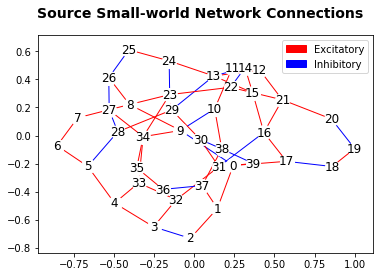

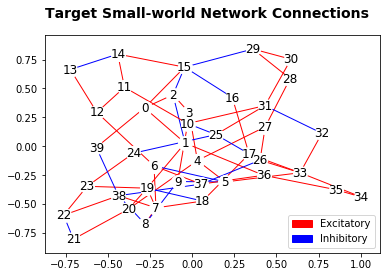

In [11]:
### Using functions in the Visualization class

cluster = vis.cluster_coeff(Graph1)
print ("For small-world network 1, the clustering co-efficient is"), cluster

# Clustering coefficient for Network 2
cluster = vis.cluster_coeff(Graph2)
print ("For small-world network 2, the clustering co-efficient is"), cluster

vis.ex_in_connec(Graph1,connect_A1,new_coord1) # This function also uses new_coord returned from AdjacencyMatrix class, 
                                               # adj_synapse_type func
suptitle('Source Small-world Network Connections', fontsize=14, fontweight='bold')
    
vis.ex_in_connec(Graph2,connect_A2,new_coord2)
suptitle('Target Small-world Network Connections', fontsize=14, fontweight='bold')

## Creating individual network simulation objects
These objects are created using the following parameters:
* N, number of neurons for each neuron group
* new_rowsx and new_colsx, source and target neuron indexes where synapses need to be formed
* connect_Wx, synaptic weights corresponding to unique connections (+ve and -ve values for excitatory and inhibitory connections respectively)
* P_Input, <font color='red'> check if we need this when we're planning to supply I_ext as Gaussian white noise </font>
* <font color='red'> Synaptic weight is 0.01 here, should it be something else?? </font>

In [12]:
# For Network 1
PInput = 0.1*volt
connect_W1 = connect_A1*volt
[G1,S1,P1] = BrianVis.network_indv(new_rows1,new_cols1,connect_W1,N,PInput)
spikemon1 = SpikeMonitor(G1)

# For Network 2
PInput = 0.1*volt
connect_W2 = connect_A2*volt
[G2,S2,P2] = BrianVis.network_indv(new_rows2,new_cols2,connect_W2,N,PInput)
spikemon2 = SpikeMonitor(G2)

WARNING    Cannot use Cython, a test compilation failed: Cython is not available (ImportError) [brian2.codegen.runtime.cython_rt.cython_rt.failed_compile_test]
INFO       Cannot use compiled code, falling back to the numpy code generation target. Note that this will likely be slower than using compiled code. Set the code generation to numpy manually to avoid this message:
prefs.codegen.target = "numpy" [brian2.devices.device.codegen_fallback]


## Coupling the networks
Individual networks created above are coupled/connected using the following parameters:
* N, number of neurons in the individual network which will be used to determine % of coupling neurons
* p_couple, probability of neurons in network that will take part in coupling <font color='red'> (not sure about the difference between manual and probabalistic coupling) </font>
* w_couple, weight of (internetwork) synaptic connections <font color='red'> does this need to have +ve and -ve values like the weights for indv networks? </font>
* G1 and G2, source and target neuron groups

In [13]:
[statemon_G1,spikemon_G1,statemon_G1c2,spikemon_G1c2,G1c2_rows,G1c2_cols,G1c2_coup_mat,S1c2] = BrianVis.network_coupling(N,p_couple,w_couple,G1,G2,'Synapse_1c2')


## Tune Network Parameters

In [18]:
# Set parameters for Network 1
G1.tau_gi = tau_gi_var
G1.I_var = sync.sync_Ivar(0.0000001)*amp

# Set parameters for Network 2
G2.tau_gi = tau_gi_var
G2.I_var = sync.sync_Ivar(0.0000001)*amp

## Run Simulation (will convert this to a class after further testing)

In [15]:
# double check if it'll be useful to have a network group in case of conflicts
#net_NG = Network(G1,S1,G2,S2,S1c2,spikemon_G1,spikemon_G1c2)

t1 = 40 # should these go up in the input section? 
t2 = 40

# 1. To begin simulation, set inter-network synaptic weights to 0. i.e. networks are not connected
# 2. Run simulation for the first t1*ms
S1c2.w = 0
run(t1*ms)
SN1 = spikemon_G1
SN2 = spikemon_G1c2
# 3. Re-establish synaptic connections
# 4. Run simulation for the next t2*ms
S1c2.w = w_couple
run(t2*ms)
SN1c = spikemon_G1
SN2c = spikemon_G1c2
# 5. Remove synaptic connections again
# 6. Run simulation for the last t1*ms 
S1c2.w = 0
run(t1*ms)


Text(0.5,0,'                               time (ms)                                    ')

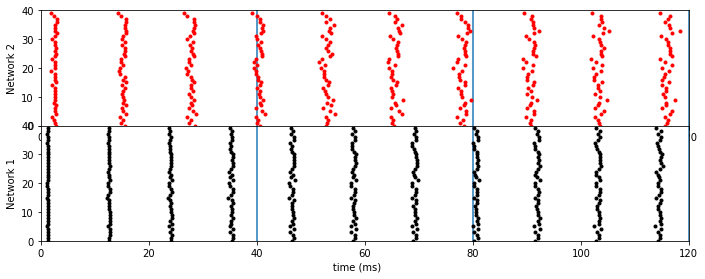

In [16]:

fig = plt.figure()

ax1 = fig.add_axes([0.1, 0.5, 1.5, 0.4], ylim=(0, 40), xlim = (0,120))

plt.axvline(x = t2)
plt.axvline(x = 2*t2)
plt.axvline(x = 3*t2)

ylabel('Network 2')

ax2 = fig.add_axes([0.1, 0.1, 1.5, 0.4], ylim=(0, 40), xlim = (0,120))

plt.axvline(x = t1)
plt.axvline(x = 2*t1)
plt.axvline(x = 3*t1)

ylabel('Network 1')


ax1.plot(SN2.t/ms, SN2.i, '.r');
ax2.plot(SN1.t/ms, SN1.i, '.k');
xlabel('                               time (ms)                                    ')                                                                        
 

